In [ ]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

##### Попробуем подобрать возможную конфигурацию свёрточной сети для задачи классификации рукописных цифр
Для начала загрузим данные

In [1]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print (X_train.shape,y_train.shape)

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


((50000L, 1L, 28L, 28L), (50000L,))


#### Посмотрим, как выглядят входные данные

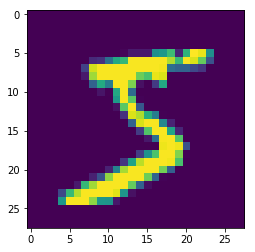

In [4]:
plt.imshow(X_train[0,0])

In [28]:
#вход у нас четырёхмерный, первый параметр задает количество примеров, второй глубину каналов, третий и четвертый - размеры входа
#у нас картинка 28 на 28
input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться"), потом идёт что-то типа глубины канала, у нас картинка чёрно-белая, поэтому
# 1, если бы была цветная, то было бы 3, как в RGB
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

#### Зададим архитектуру сети

In [40]:
# построим для начала свёрточную нейронную сеть
# архитектура нейронной сети стандартная, два свёрточных слоя, после каждого свёрточного идет пулинговый и в конце 
# полносвязный

#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

conv_1 = lasagne.layers.Conv2DLayer(input_layer, num_filters=8, filter_size=3, name='conv_1', 
                                    nonlinearity=lasagne.nonlinearities.rectify)

max_pool_1 = lasagne.layers.MaxPool2DLayer(conv_1, pool_size=(2,2), name='max_pool_1')

conv_2 = lasagne.layers.Conv2DLayer(conv_1, num_filters=8, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify, 
                                    name='conv_2')
max_pool_2 = lasagne.layers.MaxPool2DLayer(conv_2, pool_size=(2,2), name='max_pool_2')

#ВЫХОДНОЙ полносвязный слой, который имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(max_pool_2, num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')

In [41]:
#предсказание нейронки (theano-преобразование), это результат применения softmax к выходу предпоследнего слоя
y_predicted = lasagne.layers.get_output(dense_output)

In [42]:
#все веса нейронки (shared-переменные), как раз все параметры, которые будут меняться при обучении
all_weights = lasagne.layers.get_all_params(dense_output)
print (all_weights)

[conv_1.W, conv_1.b, conv_2.W, conv_2.b, output.W, output.b]


In [43]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
# первый параметр - что мы дифференцируем, потом по чему мы дифференцируем, ну и скорость обучения
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [44]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [45]:
from random import shuffle
import math

# вспомогательная функция, которая возвращает список мини-батчей для обучения нейронки

#на вход
# X - тензор из картинок размером (много, 1, 28, 28), например - X_train
# y - вектор из чиселок - ответов для каждой картинки из X; например - Y_train
#batch_size - одно число - желаемый размер группы

def iterate_minibatches(X, y, batchsize):
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield X[excerpt], y[excerpt]

#### Начинаем учить нашу сеть

In [ ]:
import time
from tqdm import tqdm

num_epochs = 50 #количество проходов по данным

batch_size = 30 #размер мини-батча

for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        
        
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

  3%|▎         | 1/30 [01:46<51:25, 106.41s/it]


  training loss (in-iteration):		0.053385
  train accuracy:		98.51 %
  validation accuracy:		98.03 %
Epoch 8 of 30 took 108.970s

 27%|██▋       | 8/30 [14:22<39:45, 108.42s/it]


  training loss (in-iteration):		0.054981
  train accuracy:		98.54 %
  validation accuracy:		97.62 %
Epoch 9 of 30 took 107.457s

 30%|███       | 9/30 [16:10<37:50, 108.13s/it]


  training loss (in-iteration):		0.050249
  train accuracy:		98.67 %
  validation accuracy:		98.20 %
Epoch 10 of 30 took 110.739s

 33%|███▎      | 10/30 [18:01<36:18, 108.91s/it]


  training loss (in-iteration):		0.050648
  train accuracy:		98.71 %
  validation accuracy:		98.14 %
Epoch 11 of 30 took 108.921s

 37%|███▋      | 11/30 [19:49<34:29, 108.92s/it]


  training loss (in-iteration):		0.049668
  train accuracy:		98.70 %
  validation accuracy:		98.02 %
Epoch 12 of 30 took 109.077s

 40%|████      | 12/30 [21:39<32:41, 108.96s/it]


  training loss (in-iteration):		0.046452
  train accuracy:		98.79 %
  validation accuracy:		98.03 %
Epoch 13 of 30 took 108.714s

 43%|████▎     | 13/30 [23:27<30:51, 108.89s/it]


  training loss (in-iteration):		0.050668
  train accuracy:		98.76 %
  validation accuracy:		98.02 %
Epoch 14 of 30 took 107.277s

 47%|████▋     | 14/30 [25:15<28:54, 108.41s/it]


  training loss (in-iteration):		0.050538
  train accuracy:		98.77 %
  validation accuracy:		98.08 %
Epoch 15 of 30 took 108.573s

 50%|█████     | 15/30 [27:03<27:06, 108.46s/it]


  training loss (in-iteration):		0.049247
  train accuracy:		98.86 %
  validation accuracy:		97.95 %
Epoch 16 of 30 took 109.949s

 53%|█████▎    | 16/30 [28:53<25:24, 108.90s/it]


  training loss (in-iteration):		0.049208
  train accuracy:		98.85 %
  validation accuracy:		97.68 %
Epoch 17 of 30 took 108.255s

 57%|█████▋    | 17/30 [30:41<23:33, 108.71s/it]


  training loss (in-iteration):		0.049342
  train accuracy:		98.86 %
  validation accuracy:		98.17 %
Epoch 18 of 30 took 108.199s

 60%|██████    | 18/30 [32:30<21:42, 108.56s/it]


  training loss (in-iteration):		0.048367
  train accuracy:		98.91 %
  validation accuracy:		97.60 %
Epoch 19 of 30 took 106.959s

 63%|██████▎   | 19/30 [34:16<19:48, 108.08s/it]


  training loss (in-iteration):		0.048268
  train accuracy:		98.96 %
  validation accuracy:		98.18 %
Epoch 20 of 30 took 107.278s

 67%|██████▋   | 20/30 [36:04<17:58, 107.84s/it]


  training loss (in-iteration):		0.047123
  train accuracy:		98.97 %
  validation accuracy:		98.20 %
Epoch 21 of 30 took 109.053s

 70%|███████   | 21/30 [37:53<16:13, 108.20s/it]


  training loss (in-iteration):		0.047477
  train accuracy:		98.99 %
  validation accuracy:		98.14 %
Epoch 22 of 30 took 107.461s

 73%|███████▎  | 22/30 [39:40<14:23, 107.98s/it]


  training loss (in-iteration):		0.045996
  train accuracy:		99.04 %
  validation accuracy:		98.07 %
Epoch 23 of 30 took 109.114s

 77%|███████▋  | 23/30 [41:29<12:38, 108.32s/it]


  training loss (in-iteration):		0.047371
  train accuracy:		98.91 %
  validation accuracy:		97.89 %
Epoch 24 of 30 took 107.426s

 80%|████████  | 24/30 [43:17<10:48, 108.05s/it]


  training loss (in-iteration):		0.046023
  train accuracy:		99.12 %
  validation accuracy:		98.36 %
Epoch 25 of 30 took 109.221s

 83%|████████▎ | 25/30 [45:06<09:02, 108.40s/it]


  training loss (in-iteration):		0.046862
  train accuracy:		99.08 %
  validation accuracy:		97.84 %
Epoch 26 of 30 took 107.814s

 87%|████████▋ | 26/30 [46:54<07:12, 108.23s/it]


  training loss (in-iteration):		0.050558
  train accuracy:		99.04 %
  validation accuracy:		97.85 %
Epoch 27 of 30 took 108.025s

 90%|█████████ | 27/30 [48:42<05:24, 108.17s/it]


  training loss (in-iteration):		0.047304
  train accuracy:		99.09 %
  validation accuracy:		97.30 %
Epoch 28 of 30 took 118.368s

 93%|█████████▎| 28/30 [50:40<03:42, 111.23s/it]


  training loss (in-iteration):		0.049988
  train accuracy:		99.17 %
  validation accuracy:		97.97 %
Epoch 29 of 30 took 111.659s

 97%|█████████▋| 29/30 [52:32<01:51, 111.36s/it]


  training loss (in-iteration):		0.050968
  train accuracy:		99.23 %
  validation accuracy:		98.22 %
Epoch 30 of 30 took 110.715s

100%|██████████| 30/30 [54:23<00:00, 111.17s/it]


  training loss (in-iteration):		0.045756
  train accuracy:		99.24 %
  validation accuracy:		98.20 %


#### Смотрим на результат обучения

In [47]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: колдун 80 уровня")
else:
    print ("Нужно больше магии!")

Final results:
  test accuracy:		98.19 %
Нужно больше магии!


In [48]:
# теперь попробуем вывести все веса нашей сети
print("params: ", lasagne.layers.get_all_param_values(dense_output))

('params: ', [array([[[[ 0.37239787,  0.09370939, -0.33846628],
         [ 0.02193911, -0.24531619, -0.41820787],
         [-0.44916324,  0.17954343,  0.06180171]]],


       [[[-0.79964815,  0.07673521,  0.00286958],
         [-0.11488024,  0.05247315,  0.10708176],
         [-0.67937882, -0.61700275, -0.33949104]]],


       [[[-0.09508422, -0.11845101,  0.06108333],
         [ 0.20175539, -0.19327865, -0.27675889],
         [-0.18521476, -0.04663817, -0.39625493]]],


       [[[-0.35462724, -1.24221189, -1.05920773],
         [-0.32598346, -0.24331355, -0.06238262],
         [ 0.95888756,  0.35534652, -0.05838728]]],


       [[[ 0.72326612,  0.48439249,  0.15746433],
         [-0.48090431,  0.26462507, -0.60353025],
         [-0.15241259, -0.21409605,  0.08005862]]],


       [[[-0.10852301,  0.09750711,  0.3558787 ],
         [-0.6426522 ,  0.03597565,  0.6668734 ],
         [-0.24464194, -0.14265984, -0.01233112]]],


       [[[ 0.2971125 ,  0.23509713,  0.23915601],
         [-0